# Building and training a convolutional neural network (CNN) to classify images of cats and dogs (Model 1)
(Based on keras.io's Image Classification from Scratch example)

First, the necessary libraries are imported, including TensorFlow and Keras. The 'os' library is also imported to interact with the operating system and delete corrupted images (Which We'll do in the next cell).

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

## Importing the Dataset
#### The Cats vs Dogs dataset
Let's download the 786M ZIP archive of the raw data. To do that we have to do the following:
1. Run '!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip' in terminal to download the .zip file of the dataset

2. Locate the downloaded kagglecatsanddogs_5340.zip file and unzip it. Rename the file to Data (for simplicity) and add it to this directory(Cat-Dog-Image-Classifer).

3. Your Dataset should be ready to use now. You can look through the PetImages folder to find thousands of cats and dogs images downloaded in separate folders, we'll be using these to train out data model

The code then checks for corrupted images and deletes them, printing the number of images deleted.
When working with lots of real-world image data, corrupted images are a common occurrence.
Let's filter out badly-encoded images that do not feature the string "JFIF" in their header

In [2]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("Data/PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


## Generate a Dataset

train_ds is used for training the machine learning model, and val_ds is used for validation. The image_dataset_from_directory() method loads images from the specified directory and returns a tf.data.Dataset object that contains the images as well as their corresponding labels.

By setting the validation_split parameter to 0.2, 20% of the data from the specified directory is used for validation and the remaining 80% is used for training. The subset parameter is set to "both" to use both the training and validation subsets of the data.

In [3]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "Data/PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.
Metal device set to: Apple M1 Max


## Using image data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

#### Here is a Visualisation of how data augmentation works

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


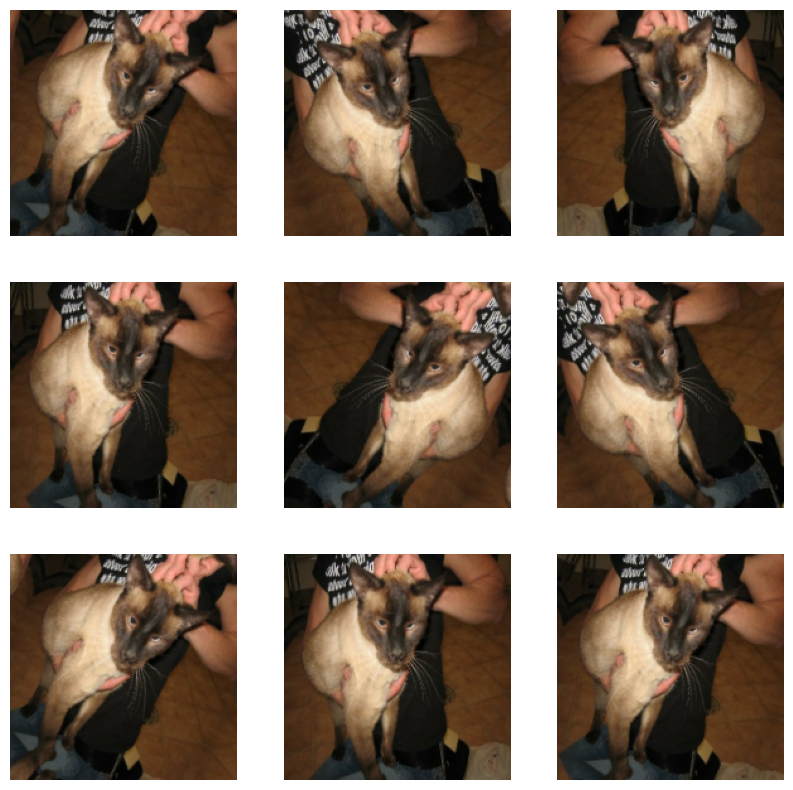

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

This code applies data augmentation to the training images, which increases the diversity of the training set and helps prevent overfitting. The map function is used to apply the data augmentation function to each image and label pair in the training set.

The prefetch function is used to load and prefetch samples in GPU memory, which can maximize GPU utilization and speed up training. Finally, val_ds is also prefetched for performance improvement.

In [7]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

#### This is a convolutional neural network (CNN) that consists of the following layers:

1. Input layer that accepts images with a shape of `image_size + (3,)`
2. A rescaling layer that scales the pixel values of the input image to the range of [0,1].
3. A convolutional layer with 128 filters, a kernel size of 3, and a stride of 2, followed by batch normalization and ReLU activation.
4. Three blocks of two separable convolutional layers with increasing numbers of filters (256, 512, and 728), each block ends with a max-pooling layer, a projection of the residual connection from the previous block (if applicable), and an element-wise addition with the output of the max-pooling layer.
5. A final separable convolutional layer with 1024 filters, followed by batch normalization and ReLU activation.
6. A global average pooling layer that computes the spatial average of the feature maps, resulting in a fixed-size feature vector regardless of the input image size.
7. A dropout layer with a rate of 0.5 to reduce overfitting.
8. A fully connected output layer with a sigmoid activation function (if there are two classes) or softmax activation (if there are more than two classes).

The model architecture follows a common pattern used in many state-of-the-art CNNs, with a series of convolutional layers followed by some pooling layers, residual connections, batch normalization, and nonlinear activation functions, all aiming to extract useful features from the input image and classify it into one of the output classes.

### You can see the structure of the model in a more visual form at the end thanks to keras's plot_model function

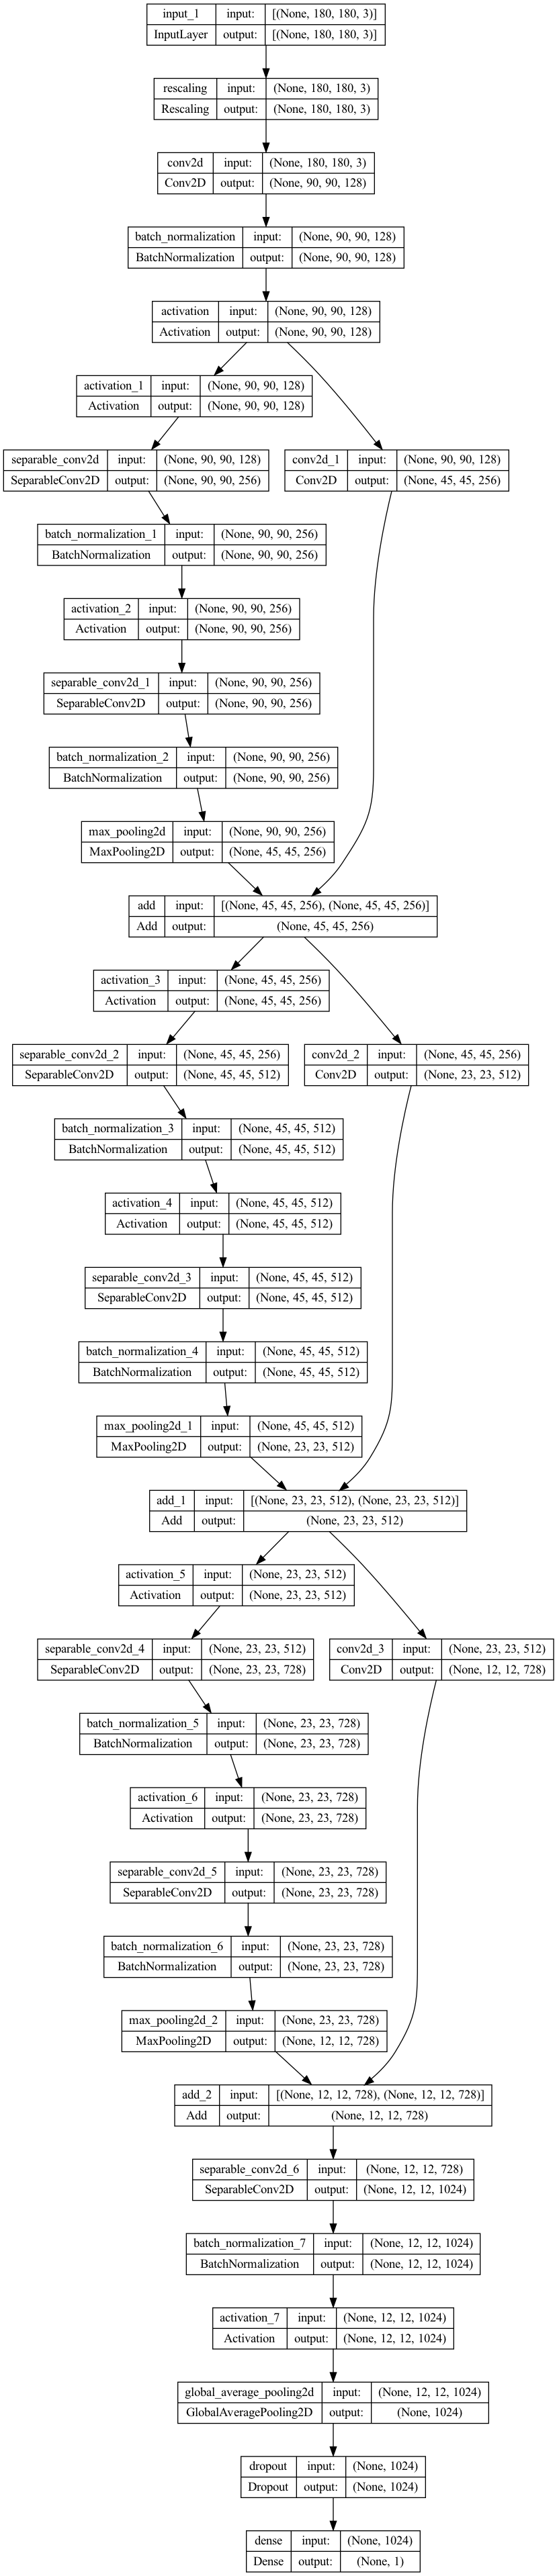

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Model Training Process

This code is used to train a deep learning model on some data. The model will be trained for 25 epochs, which means it will go through the entire training dataset 25 times.

During training, a checkpoint will be saved at the end of each epoch. This allows us to resume training from where we left off if we need to stop the training process for any reason.

The model will be compiled using the Adam optimizer with a learning rate of 1e-3, and the binary cross-entropy loss function and accuracy metrics will be used to evaluate the performance of the model.

The model will then be trained on the training dataset (train_ds) for the specified number of epochs, and the validation dataset (val_ds) will be used to monitor the model's performance during training. The training progress will be monitored by the callbacks, and the saved checkpoints can be used later to evaluate the performance of the model on new data.

#### NOTE: This process can take a long time depending on your system as goes through thousands of images classifying them. For reference I used a Macbook Pro with M1 Max (32 Core) and 32 GB RAM and it took 1h 11m to train the model

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.legacy.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

### Testing the Model
After we've finished the training process we can test on random images to see how our model performs, just change the path value in keras.preprocessing.image.load_img function to test the model on your own image. Although you can do the same later on using the models_comparison.py file to see what kind of different results the other models give.

In [ ]:
img = keras.preprocessing.image.load_img(
    "Data/PetImages/Cat/340.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

In [ ]:
model.save('/Users/priynshkumar/Developer/Python/ArtificialIntelligence/Personal Practice/Image_Classification')

In [ ]:
img = keras.preprocessing.image.load_img(
    "/Users/priynshkumar/Developer/Python/ArtificialIntelligence/Personal Practice/Image_Classification/kagglecatsanddogs_5340/PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model2.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")